<a href="https://colab.research.google.com/github/tomncu107/tonyproject/blob/master/predicting-occupation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = ("/content/gdrive/My Drive/occupation data.rar")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unrar x "/content/gdrive/My Drive/vita/occupation data.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/gdrive/My Drive/vita/occupation data.rar

Creating    occupation                                                OK
Creating    occupation/manager                                        OK
Extracting  occupation/manager/管理_200413_0001.jpg                          0%  OK 
Extracting  occupation/manager/管理_200413_0002.jpg                          2%  OK 
Extracting  occupation/manager/管理_200413_0003.jpg                          3%  OK 
Extracting  occupation/manager/管理_200413_0004.jpg                          3%  OK 
Extracting  occupation/manager/管理_200413_0005.jpg                          3%  OK 
Extracting  occupation/manager/管理_200413_0006.jpg                          3%  OK 
Extracting  occupation/manager/管理_200413_0007.jpg                          5%  OK 
Extracting  occupation/manager/管理_200413_0008.jpg                        

[INFO] loading image...
[INFO] compiling model...
[INFO] training head...
Epoch 1/20
23/23 [==============================] - 23s 1s/step - loss: 1.4865 - accuracy: 0.3536 - val_loss: 1.0941 - val_accuracy: 0.4565
Epoch 2/20
23/23 [==============================] - 22s 964ms/step - loss: 1.0786 - accuracy: 0.4365 - val_loss: 1.0286 - val_accuracy: 0.5870
Epoch 3/20
23/23 [==============================] - 22s 966ms/step - loss: 1.0106 - accuracy: 0.5028 - val_loss: 0.9829 - val_accuracy: 0.5870
Epoch 4/20
23/23 [==============================] - 22s 970ms/step - loss: 0.9557 - accuracy: 0.5138 - val_loss: 0.9685 - val_accuracy: 0.5870
Epoch 5/20
23/23 [==============================] - 22s 968ms/step - loss: 0.9026 - accuracy: 0.5525 - val_loss: 0.9215 - val_accuracy: 0.6522
Epoch 6/20
23/23 [==============================] - 22s 967ms/step - loss: 0.8763 - accuracy: 0.6188 - val_loss: 0.8964 - val_accuracy: 0.6304
Epoch 7/20
23/23 [==============================] - 22s 966ms/step - lo

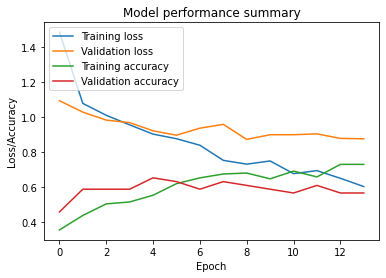

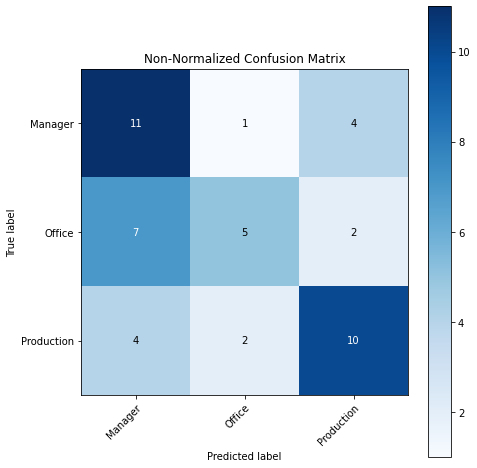

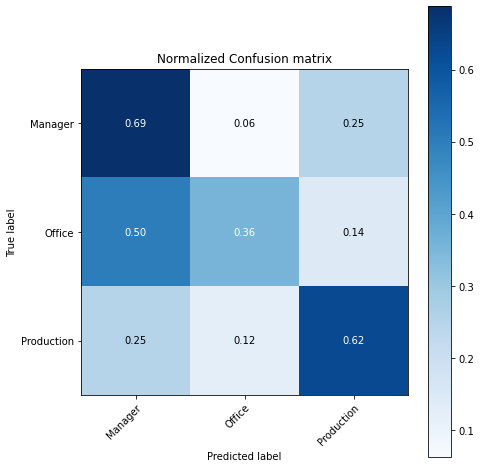

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, VGG16, ResNet50, Xception, InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time


# initialize the learning rate, number of epochs and batch size
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 8

checkpointer = ModelCheckpoint(filepath="save/cnn_mnist.hdf5", verbose=0, save_best_only=True) # save best model

# load the dataset
print("[INFO] loading image...")
image_paths = list(paths.list_images("/content/occupation")) #directory
data = []
labels = []
from skimage import io
# loop over the image paths
for image_path in image_paths:
    # load the image => convert from BGR to RGB => resize into 224x224
    image = io.imread(image_path)
    
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224), cv2.INTER_NEAREST)
    data.append(image)

    # load the label
    label = image_path.split(os.path.sep)[-2]
    labels.append(label)

# convert data and label into numpy and scale the data pixel intensity value into range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# split data into trainset and testset with ratio 80-20 respectively
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.transform(test_labels)
#labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
#print(labels)



# initialize the training data augmentation object
# SAMPLE: aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
# 	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
# 	horizontal_flip=True, fill_mode="nearest")
train_augment = ImageDataGenerator(rotation_range=15, fill_mode="nearest")


# load VGG16 network, ensuring the head FC layer sets are left off
base_model = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten(name="flatten") (head_model)
head_model = Dense(64, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(len(lb.classes_), activation="softmax")(head_model)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs = head_model)

# loop over all layer in the base model and freeze them so they will not updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

# compile the model
print("[INFO] compiling model...")
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
start = time.time()
#H = model.fit_generator(train_augment.flow(train_data, train_labels, batch_size=BATCH_SIZE), steps_per_epoch=len(train_data)//BATCH_SIZE, validation_data=(test_data, test_labels), validation_steps=len(test_data)//BATCH_SIZE, epochs=EPOCHS)
H = model.fit(train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_data, test_labels), callbacks=[monitor,checkpointer])
end = time.time()

train_time = end-start
print("Total training time is {:0.2f} minute".format(train_time/60.0))


# make predictions on the testing set
print("[INFO] evaluating network...")
pred_idxs = model.predict(test_data, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
pred_idxs = np.argmax(pred_idxs, axis=1)

# show classification report
print(classification_report(np.argmax(test_labels, axis=1), pred_idxs, target_names=lb.classes_))

#plot confusion matrix
from sklearn.metrics import confusion_matrix

y_true = np.argmax(test_labels, axis=1) 
y_pred = pred_idxs

#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names=['Manager', 'Office', 'Production']




# plot the training loss and accuracy
N = EPOCHS
# plot summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model performance summary')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss', 'Training accuracy', 'Validation accuracy'], loc='upper left')

#Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, title = 'Non-Normalized Confusion Matrix')

#Plotting normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names, normalize = True, title= 'Normalized Confusion matrix')


# save the model
#print("[INFO] saving occupation detector model...")
#model.save("model", save_format="h5")

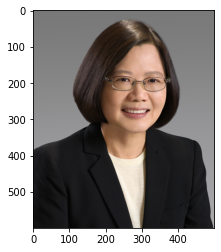

This guy should be in Office


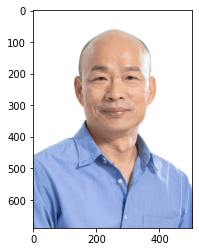

This guy should be in Manager


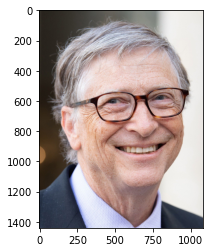

This guy should be in Manager


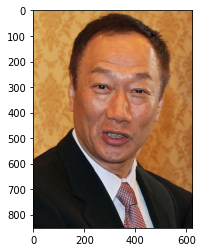

This guy should be in Manager


In [ ]:
import numpy as np
from PIL import Image
from keras.preprocessing import image
import matplotlib.pyplot as plt

#image = io.imread("/content/hr.png")



image_paths = list(paths.list_images("/content/test")) #directory

from skimage import io
# loop over the image paths
for image_path in image_paths:
  image = io.imread(image_path)
  plt.imshow(image)
  plt.show()
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224), cv2.INTER_NEAREST)
  image = np.array(image) / 255.0
  
  image = image.reshape(1,224,224,3)
  pred_idxs = model.predict(image)
  pred_idxs = np.argmax(pred_idxs, axis=1)

  if pred_idxs == 0:
    print("This guy should be in Manager")
  elif pred_idxs == 1:
    print("This guy should be in Office")
  elif pred_idxs == 2:
    print("This guy should be in Production")
  else:
    print("This model failed to prediction")


